# Training Car Recognition

In [0]:
import os
from scipy.io import loadmat
from pathlib import Path
import pandas as pd
import cv2 as cv
from tqdm import tqdm

import fastai
from fastai.vision import *
from fastai.metrics import error_rate

ROOT_DIR = Path('/content')
DATA_DIR = ROOT_DIR/'data'
META_DIR= ROOT_DIR/'devkit'
MODEL_DIR = ROOT_DIR/'model'

os.makedirs(MODEL_DIR, exist_ok=True)

## Download Training Data

In [143]:
# Load once

!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz

--2019-06-17 13:43:50--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K  1.10MB/s    in 0.3s    

2019-06-17 13:43:51 (1.10 MB/s) - ‘car_devkit.tgz’ saved [330960/330960]

--2019-06-17 13:43:52--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  19.7MB/s    in 87s     

2019-06-17 13:45:19 (10.7 MB/s) - ‘cars_train.tgz’ saved 

In [0]:
!tar -zxf car_devkit.tgz
!tar -zxf cars_train.tgz

## Retrieve Data Annotations

In [0]:
def load_annos(meta_dir, mat_file, labels=True):
  '''Load annotation data'''
  
  annos = {}
  keys = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
  
  if labels:
    keys = keys + ['class']

  data = loadmat(meta_dir/mat_file)
  data = data['annotations']

  for key in keys:
    values = data[key][0]
    if key == 'fname':
      values = [y for x in values for y in x]
    else:
      values = [y[0] for x in values for y in x]
    
    annos[key] = values
    
  return annos

In [0]:
train_annos = load_annos(META_DIR, mat_file='cars_train_annos.mat')

In [0]:
def load_classes(meta_dir):
  '''List of classes
  :param meta_dir: 
  :return: idx to class dict
  '''
  classes = loadmat(meta_dir/'cars_meta.mat')
  classes = classes['class_names'][0]
  classes = [y for x in classes for y in x]
  idx_to_class = {idx+1:clss for idx, clss in enumerate(classes)}
  
  return idx_to_class


In [157]:
classes = load_classes(META_DIR)
classes[14], classes[19]

('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011')

## Preprocess Images

In [0]:
def crop_images(src_folder, annos):
  
  margin = 16
  num_samples = len(annos['fname'])
  
  for i in tqdm(range(num_samples)):
    fname = annos['fname'][i]
    x1 = annos['bbox_x1'][i]
    y1 = annos['bbox_y1'][i] 
    x2 = annos['bbox_x2'][i] 
    y2 = annos['bbox_y2'][i] 
    
    src_path = ROOT_DIR/src_folder/fname
    src_img = cv.imread(str(src_path))
    h, w = src_img.shape[:2]
    
    x1 = max(0, x1 - margin)
    y1 = max(0, y1 - margin)
    x2 = min(x2 + margin, w)
    y2 = min(y2 + margin, h)
    
    dst_folder = DATA_DIR/f'crop_{src_folder}'
    dst_path = dst_folder/fname
    os.makedirs(dst_folder, exist_ok=True)
    
    crop_img = src_img[y1:y2, x1:x2]
    cv.imwrite(str(dst_path), crop_img)

In [151]:
crop_images('cars_train', train_annos)

100%|██████████| 8144/8144 [01:16<00:00, 110.55it/s]


## Data Loader

In [0]:
bs = 16
train_path = DATA_DIR/'crop_cars_train'
df = pd.DataFrame({'name':train_annos['fname'], 'label':train_annos['class']})
data = ImageDataBunch.from_df(train_path, df, ds_tfms=get_transforms(), size=299, bs=bs).normalize(imagenet_stats)

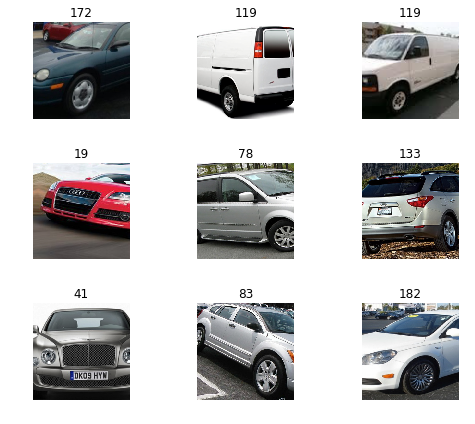

In [153]:
data.show_batch(rows=3, figsize=(7,6))

# Training: pretrained resnet152

In [0]:
learn = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy]).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


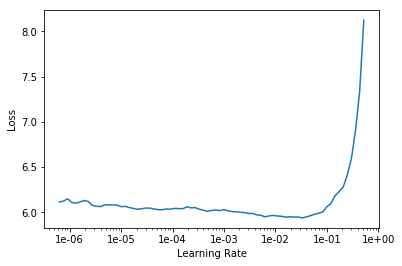

In [110]:
learn.lr_find()
learn.recorder.plot()

In [111]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.757947,3.753681,0.817568,0.182432,04:26
1,3.845711,2.485110,0.579853,0.420147,04:23
2,3.198205,1.770070,0.418919,0.581081,04:22
3,2.829946,1.624400,0.377764,0.622236,04:22


In [112]:
learn.save(MODEL_DIR/'stage-1-152-c', return_path=True)

PosixPath('/content/model/stage-1-152-c.pth')

In [113]:
learn.unfreeze()
learn.fit_one_cycle(25, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.726296,1.554310,0.374693,0.625307,05:42
1,2.675127,1.416107,0.334152,0.665848,05:40
2,2.538765,1.256175,0.288698,0.711302,05:40
3,2.450627,1.101048,0.262285,0.737715,05:40
4,2.368057,0.957654,0.227887,0.772113,05:40
5,2.141445,0.877066,0.208845,0.791155,05:40
6,2.223240,0.820616,0.218059,0.781941,05:43
7,2.156546,0.749474,0.186118,0.813882,05:42
8,1.980802,0.693232,0.173833,0.826167,05:40
9,1.845389,0.668384,0.171990,0.828010,05:40


In [127]:
learn.save(MODEL_DIR/'stage-2-152-c', return_path=True)

PosixPath('/content/model/stage-2-152-c.pth')

In [0]:
# Export trained model for inference

learn.export(MODEL_DIR/'stage-2-152-c.pkl')

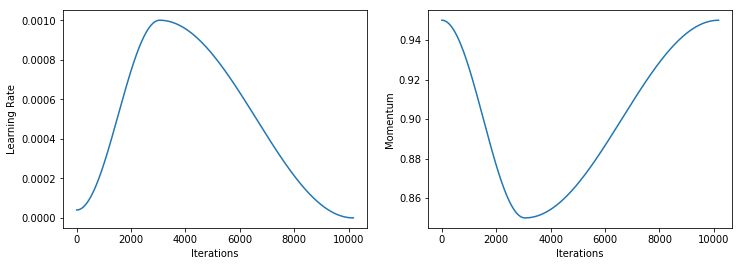

In [129]:
learn.recorder.plot_lr(show_moms=True)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

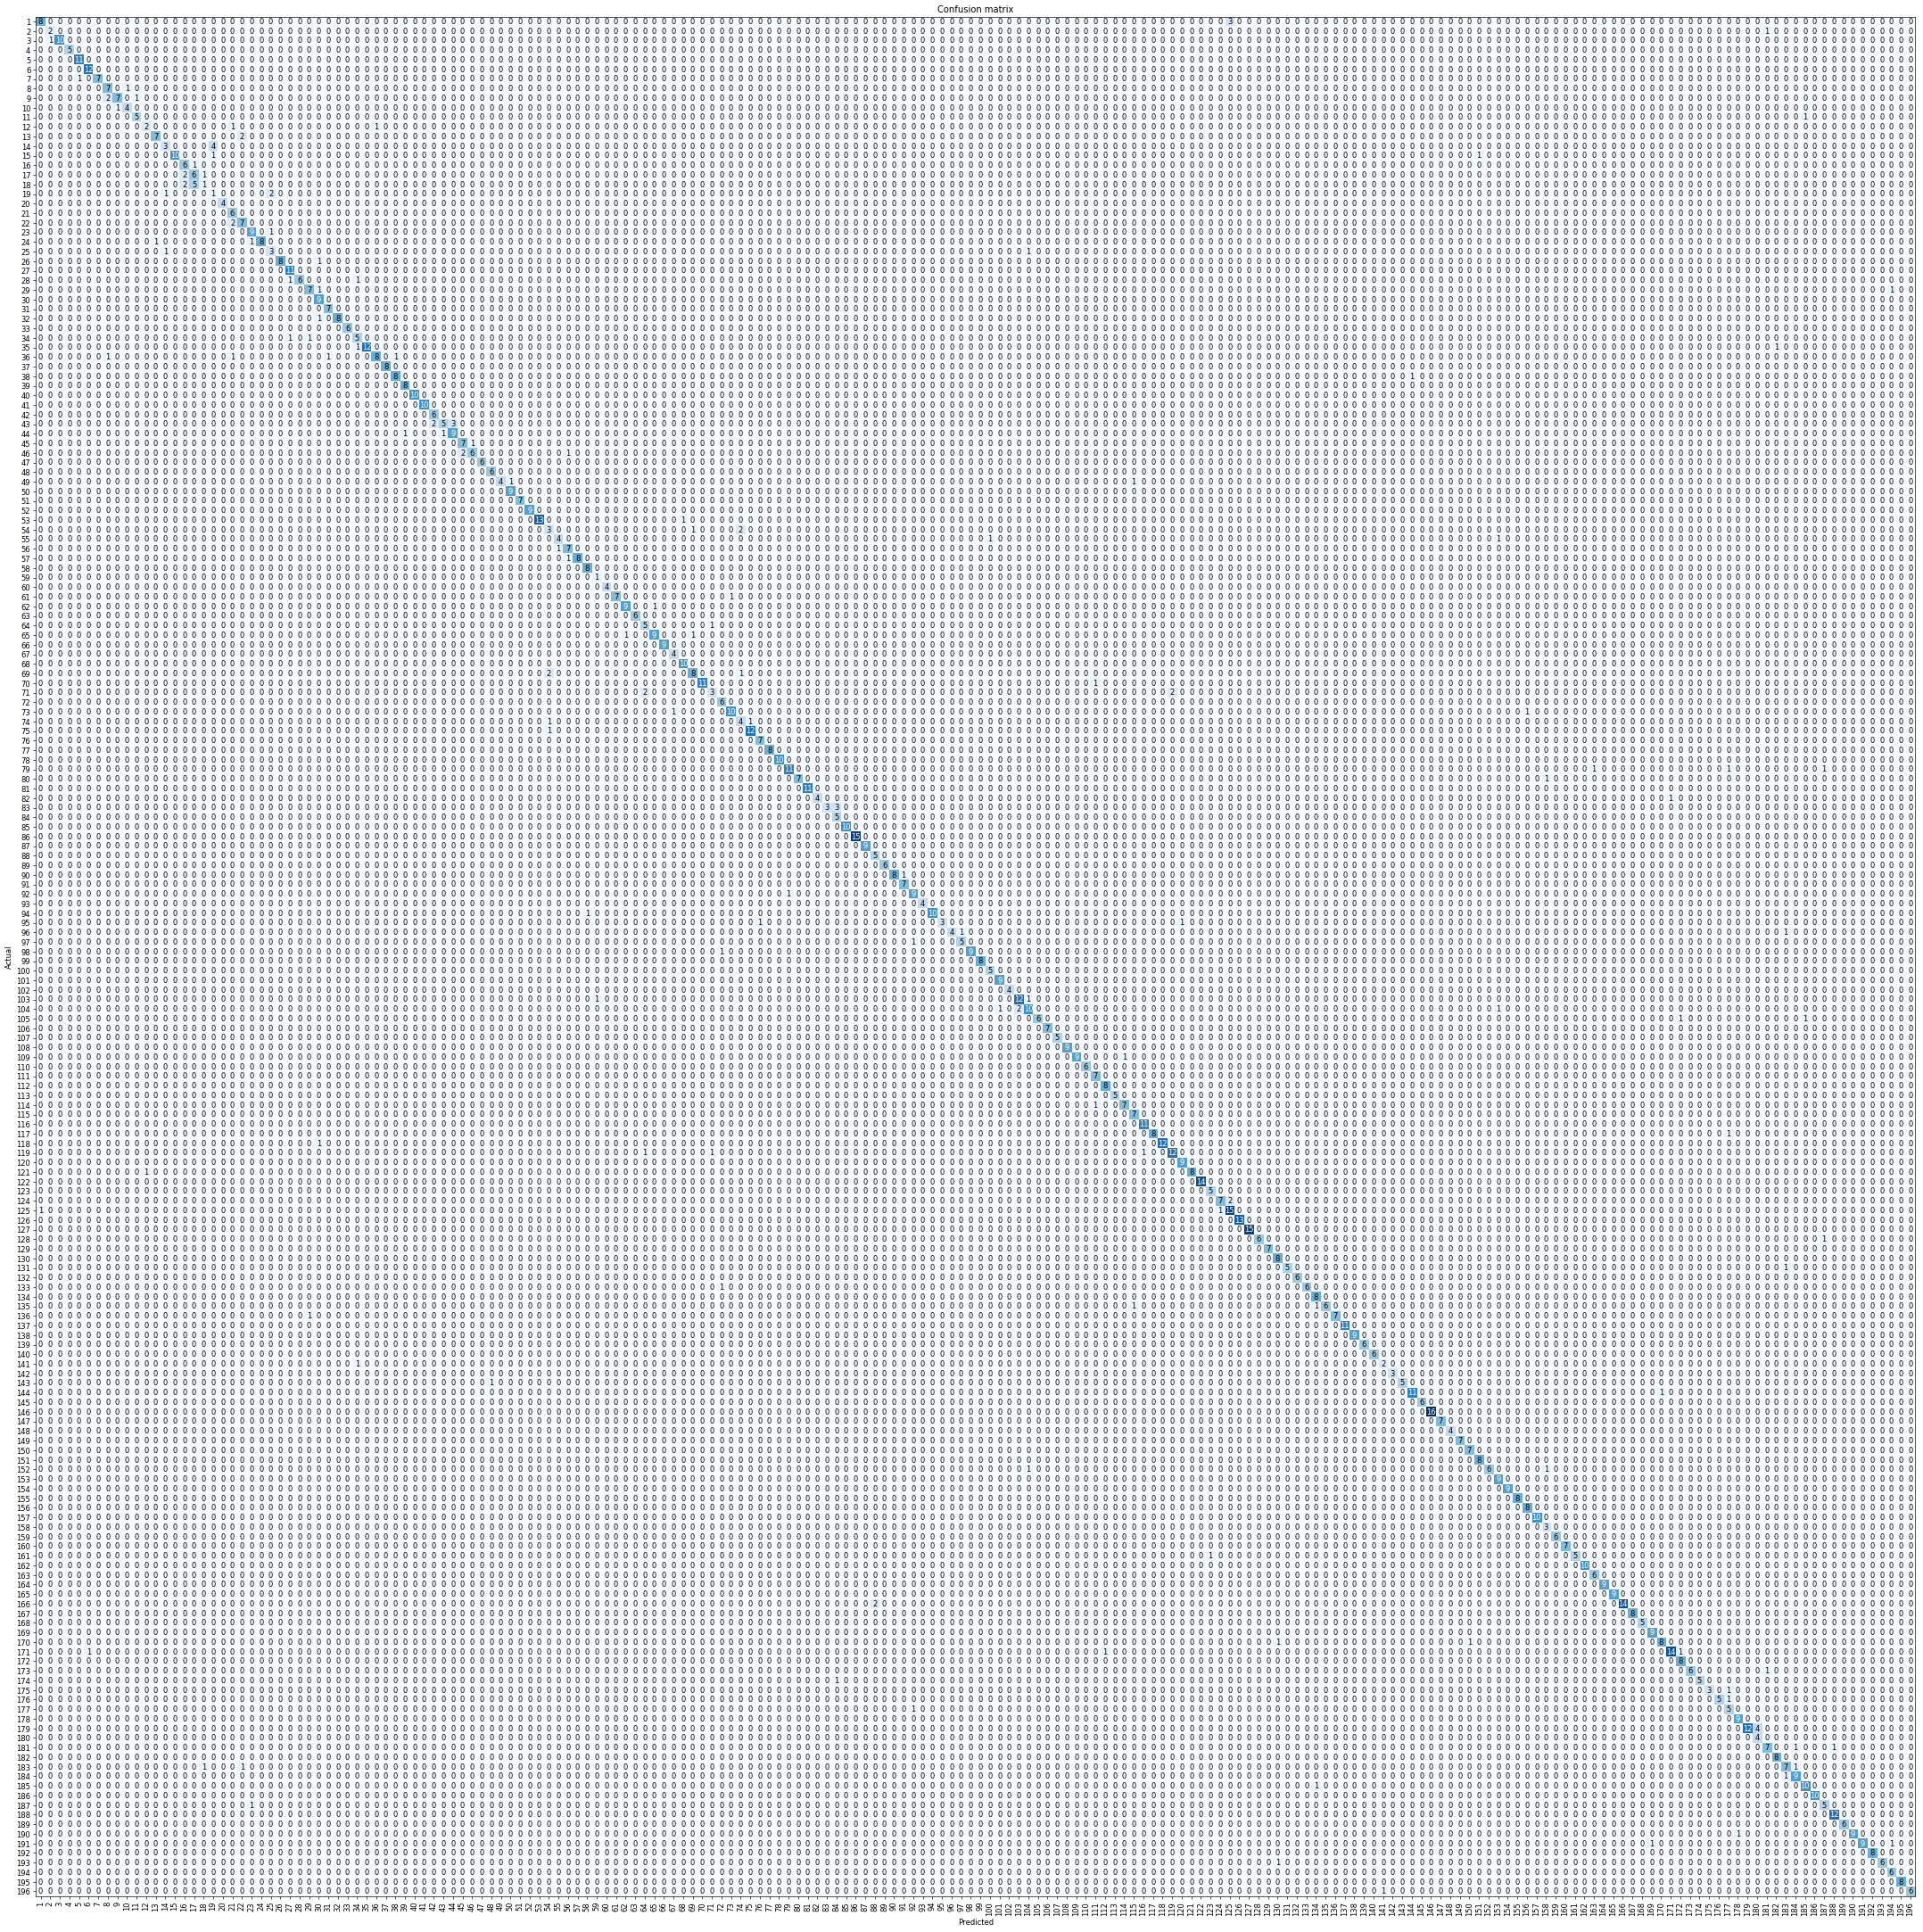

In [155]:
interp.plot_confusion_matrix(figsize=(36,36), dpi=60)

In [154]:
interp.most_confused(min_val=2)

[(18, 17, 5),
 (14, 19, 4),
 (179, 180, 4),
 (1, 125, 3),
 (43, 44, 3),
 (83, 84, 3),
 (9, 8, 2),
 (13, 22, 2),
 (17, 16, 2),
 (18, 16, 2),
 (19, 25, 2),
 (22, 21, 2),
 (43, 42, 2),
 (46, 45, 2),
 (54, 74, 2),
 (69, 54, 2),
 (71, 64, 2),
 (71, 119, 2),
 (104, 103, 2),
 (124, 125, 2),
 (166, 88, 2)]